In [1]:
from __future__ import division
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy as scp
import pylab as pyl

import warnings
warnings.filterwarnings('ignore')
np.random.seed(1234)

%matplotlib inline
%load_ext autoreload
%autoreload 

In [2]:
if not os.path.isdir('DampedNewtonVsSinkhorn_benchmark_annulusVSsquare_images'):
    os.makedirs('DampedNewtonVsSinkhorn_benchmark_annulusVSsquare_images')

In [3]:
def p_norms(x,y,p):
   
   if p == 1:
      
      return  abs(np.sum(x,0)[:,None]-np.sum(y,0)[None,:])  
   
   elif p == 2:
      return  np.sum( x**2,0 )[:,None] + np.sum( y**2,0 )[None,:] - 2*x.transpose().dot(y)
   
   elif p == 4:
    return np.sum( x**4,0 )[:,None] + np.sum( y**4,0 )[None,:] + 4*(x**3).transpose().dot(y) - 4*x.transpose().dot(y**3) + 6*(x**2).transpose().dot(y**2)

   elif p == 'inf':
      return np.maximum(abs(x[0,:][:,None]-y[0,:][None,:]),abs(x[1,:][:,None] - y[1:][None:]))




"""To compute distance matrix"""
def distmat(x,y):
    return np.sum( x**2,0 )[:,None] + np.sum( y**2,0 )[None,:] - 2*x.transpose().dot(y)

"""To Normalise a vector"""
normalize = lambda a: a/np.sum( a )

"""To Compute P"""
def GetP(u,K,v):
    return u[:,None]*K*v[None,:]

def plotp(x, col,plt, scale=200, edgecolors="k"):
  return plt.scatter( x[0,:], x[1,:], s=scale, edgecolors=edgecolors,  c=col, cmap='plasma', linewidths=2 )

In [4]:
import computational_OT

In [5]:
def spectral_decomposition(mat):
    eig, v = np.linalg.eigh( mat )
    sorting_indices = np.argsort(eig)
    eig = eig[sorting_indices]
    v   = v[:, sorting_indices]
    
    print( "List of smallest eigenvalues: ", eig[:10])
    print( "List of largest  eigenvalues: ", eig[-10:])

    return eig,v

In [6]:
def build_preconditioners( num_eigs,modified_Hessian,N, ansatz=True ):
    # Diagonalize
    eigenvalues, eigenvectors = np.linalg.eigh( modified_Hessian )
    sorting_indices = np.argsort( eigenvalues )
    eigenvalues  = eigenvalues[sorting_indices]
    eigenvectors = eigenvectors[:, sorting_indices]
    # Form null vector
    if not ansatz:
        null_vector = eigenvectors[:, 0]
    else:
        null_vector = np.hstack( (np.ones(N[0]), -np.ones(N[1])) )
        norm = np.sqrt( N[0] + N[1] )
        null_vector = null_vector/norm
    # Form other vectors (only 13)
    n,m = eigenvectors.shape
    indices=[]
    for i in range(num_eigs//2):
        indices.append(m-i-1)
        indices.append(i+1)
    if num_eigs//2!=0:
        indices.append(m-1-num_eigs//2)
   
    precond_vectors = eigenvectors[:, indices ]
    precond_vectors = []
    for index in indices:
        precond_vectors.append( eigenvectors[:,index] )
    #
    return null_vector, precond_vectors

In [7]:
N = [ 1000,1200 ]
epsilons = [ 0.1,0.09,0.05,0.03 ] 


In [8]:
x = np.random.rand( 2,N[0] ) - 0.5
theta = 2*np.pi*np.random.rand( 1,N[1] )
r = 0.8+.2*np.random.rand( 1,N[1] )
y = np.vstack( ( r*np.cos( theta ),r*np.sin( theta ) ) )

# L-1 norm

## Sinkhorn

In [9]:
# Sinkhorn
print("Sinkhorn.... ")
SinkhornP=[]
results_Sinkhorn=[]
times_Sinkhorn=[]
for eps in epsilons:

  
  #Cost matrix
  C = p_norms(x,y,2)
  
  # a and b
  a = normalize(np.ones(N[0]))
  a = a.reshape(a.shape[0],-1)
  b = normalize(np.ones(N[1]))
  b = b.reshape(b.shape[0],-1)



  #Kernel
  K = np.exp(-C/eps)


  print( "Doing for (",N[0],N[1],") and epsilon = " +str(eps)+ " ." )
  print( " |- Iterating" )

  #Inflating
  u = a
  v = b

  start = time.time()
  Optimizer = computational_OT.Sinkhorn( K,a,b,u,v,eps)
  out = Optimizer._update(maxiter=10000)
  results_Sinkhorn.append( out )
  end = time.time()
  times_Sinkhorn.append( end-start )
  print( " |- Computing P" )
  print( "" )
  SinkhornP.append(GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)))
  

Sinkhorn.... 
Doing for ( 1000 1200 ) and epsilon = 0.1 .
 |- Iterating
Terminating after iteration:  109
 |- Computing P

Doing for ( 1000 1200 ) and epsilon = 0.09 .
 |- Iterating
Terminating after iteration:  121
 |- Computing P

Doing for ( 1000 1200 ) and epsilon = 0.05 .
 |- Iterating
Terminating after iteration:  225
 |- Computing P

Doing for ( 1000 1200 ) and epsilon = 0.03 .
 |- Iterating
Terminating after iteration:  385
 |- Computing P



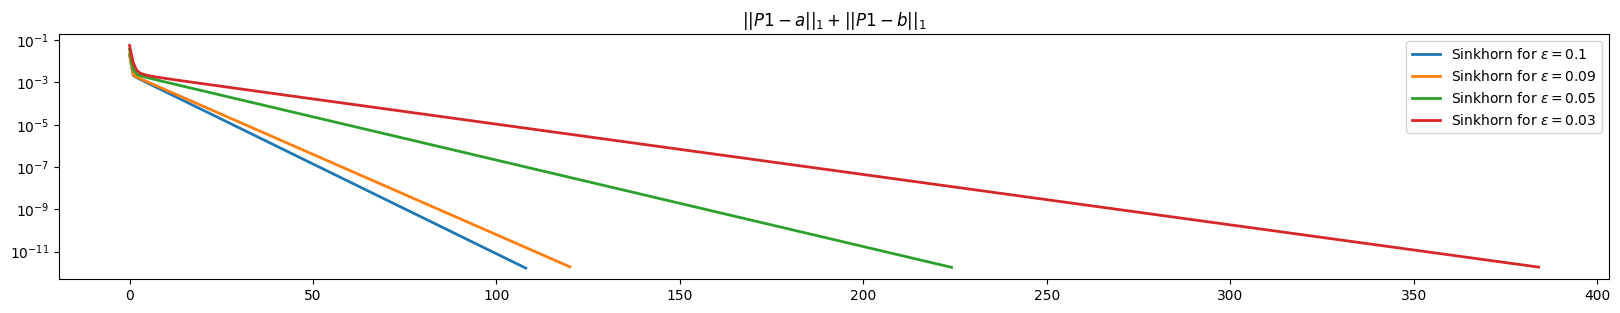

In [10]:
plt.figure( figsize = (20,7) )

plt.subplot(2,1,1),
plt.title( "$||P1 -a||_1+||P1 -b||_1$" )
for i in range( len(results_Sinkhorn) ):
  error=np.asarray( results_Sinkhorn[i]['error_a'] )+np.asarray( results_Sinkhorn[i]['error_b'] )
  plt.plot( error,label='Sinkhorn for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )
plt.yscale( 'log' )
plt.legend()

plt.savefig("DampedNewtonVsSinkhorn_benchmark_annulusVSsquare_images/ConvergenceSinkhornvaryingepsilonL1.png")
plt.show()

In [11]:
rho = 0.95
c = 0.05
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []
Hessians_DampedNewton = []

for eps in epsilons:
    # Line Search
    print( "Damped Newton for epsilon = "+str(eps)+":" )    
    #Cost matrix
    C = p_norms(x,y,1)

    # a and b
    a = normalize( np.ones( N[0] ) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones( N[1] ) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)
    f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton( K,a,b,f,g,eps,rho,c )
    out = Optimizer._update( maxiter=50 )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append( end-start )
    print( " |- Computing P" )
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    print( " |- Recording (unstabilized) Hessian \n" )

    mat  = -eps*Optimizer.Hessian
    diag = 1/np.sqrt( np.vstack( (a,b) ) ).flatten()
    mat = diag[:,None]*mat*diag[None,:]
    Hessians_DampedNewton.append( mat )
    

Damped Newton for epsilon = 0.1:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  20
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.09:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  17
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.05:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.03:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  21
 |- Computing P
 |- Recording (unstabilized) Hessian 



In [12]:
eigs = []
eigvecs = []
for i in range( len(epsilons) ) :
    eps = epsilons[i]
    print( "Spectral statistics of Hessian for epsilon="+str(eps) )
    ev = spectral_decomposition( Hessians_DampedNewton[i] )
    eigs.append( ev[0] )
    eigvecs.append( ev[1] )
    print("")


Spectral statistics of Hessian for epsilon=0.1
List of smallest eigenvalues:  [-6.85184909e-16  8.33866577e-02  4.90813292e-01  6.28859061e-01
  7.33452898e-01  8.05622251e-01  8.45921388e-01  8.67262360e-01
  8.91767838e-01  9.10277457e-01]
List of largest  eigenvalues:  [1.08972254 1.10823216 1.13273764 1.15407861 1.19437775 1.2665471
 1.37114094 1.50918671 1.91661334 2.        ]

Spectral statistics of Hessian for epsilon=0.09
List of smallest eigenvalues:  [-7.68722853e-16  7.46709883e-02  4.78892576e-01  6.14345749e-01
  7.20651942e-01  7.93993865e-01  8.37260952e-01  8.59418934e-01
  8.83341889e-01  9.04018920e-01]
List of largest  eigenvalues:  [1.09598108 1.11665811 1.14058107 1.16273905 1.20600614 1.27934806
 1.38565425 1.52110743 1.92532901 2.        ]

Spectral statistics of Hessian for epsilon=0.05
List of smallest eigenvalues:  [4.70448534e-16 4.04778752e-02 4.25211315e-01 5.45594562e-01
 6.57590196e-01 7.31378951e-01 7.88385026e-01 8.23328273e-01
 8.42295805e-01 8.6234366

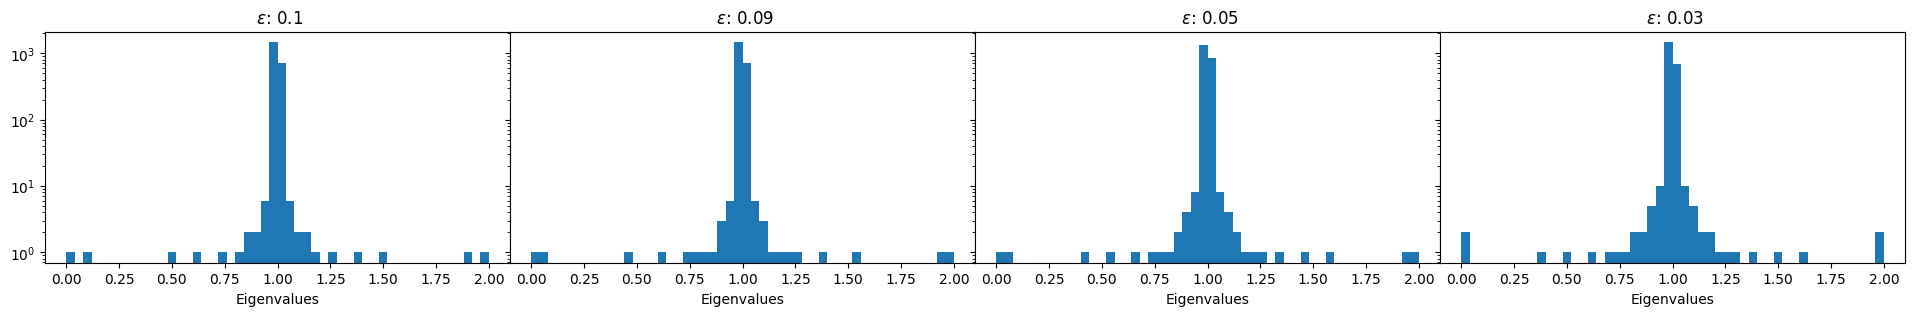

In [13]:
fig,ax = plt.subplots( figsize=(24,3),nrows=1, ncols=len(epsilons), sharey=True )
plt.title( "Histogram of eigenvalues." )
for i in range( len(epsilons) ):
    ax[i].hist( eigs[i], 50 )
    ax[i].set_title( " $\epsilon$: "+str(epsilons[i]) )
    ax[i].set_xlabel( "Eigenvalues" )
    ax[i].set_yscale( "log" )
plt.subplots_adjust( wspace=0,hspace=0 )
plt.savefig("DampedNewtonVsSinkhorn_benchmark_annulusVSsquare_images/eigenhistunstabilizedL1.png")
plt.show()

In [14]:
num_eigs = 10
null_vector, precond_vectors = build_preconditioners( num_eigs, Hessians_DampedNewton[-1],N, ansatz=False )

In [15]:
rho = 0.95
c = 0.05
reset_starting_point = True
final_modified_Hessians = []
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []

#epsilons = [ 0.3 ]
f, g = None, None
for eps in epsilons:
    # Line Search
    print( "Damped Newton for epsilon="+str(eps)+":" )    
    # Cost matrix
    C = p_norms(x,y,1)

    # a and b
    a = normalize( np.ones(N[0]) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones(N[1]) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)

    if (f is None) or (g is None): 
        f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton_With_Preconditioner( K,a,b,f,g,eps,rho,c,null_vector,precond_vectors[:] )
    out = Optimizer._update( maxiter=50, iterative_inversion=30, version=None,debug=False,optType='cg' )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P" )

    if not reset_starting_point:
        f = Optimizer.x[:a.shape[0]]
        g = Optimizer.x[a.shape[0]:]
        # f = f.reshape( f.shape[0], -1)
        # g = g.reshape( g.shape[0], -1)
    
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    final_modified_Hessians.append( Optimizer.modified_Hessian )


Damped Newton for epsilon=0.1:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  51
 |- Computing P
Damped Newton for epsilon=0.09:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  3
 |- Computing P
Damped Newton for epsilon=0.05:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  51
 |- Computing P
Damped Newton for epsilon=0.03:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  51
 |- Computing P


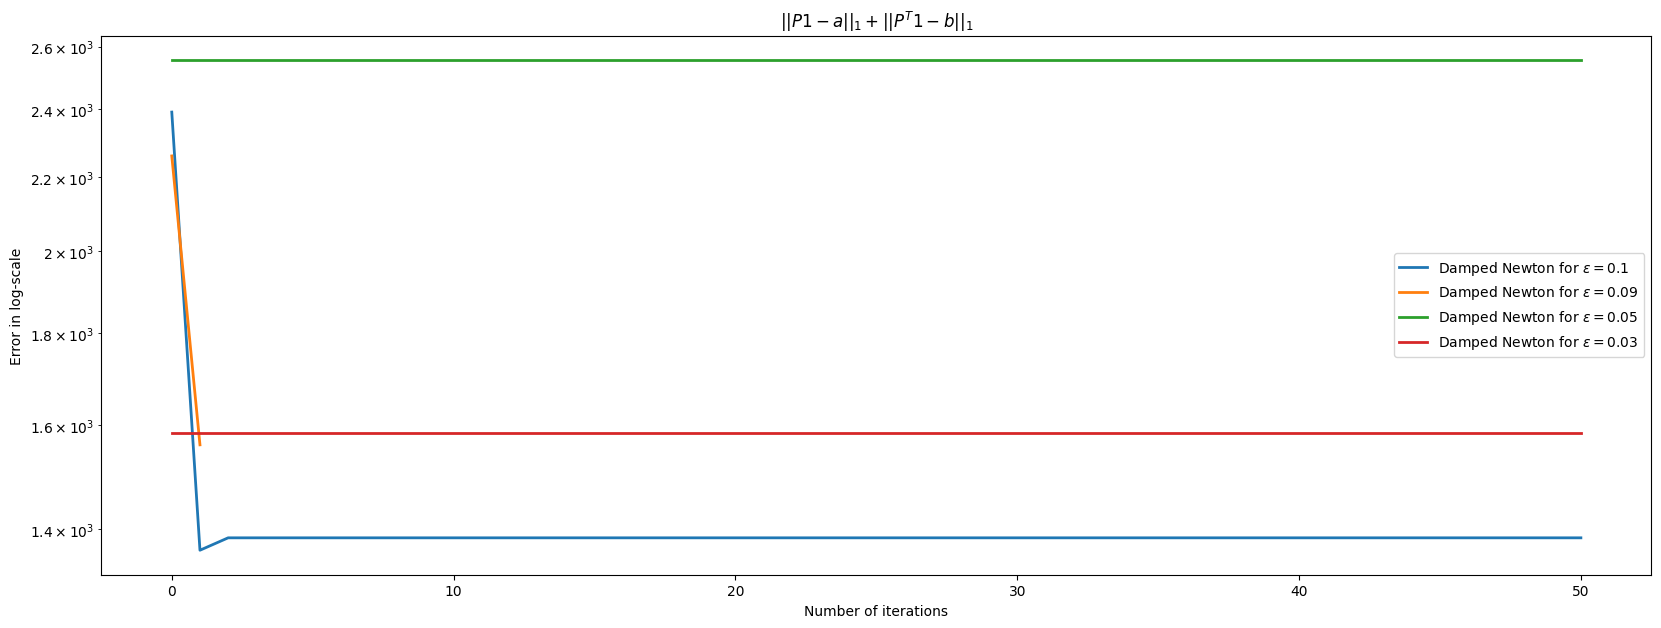


 Error plots can increase! The error is not the objective function!


In [16]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" )

for i in range( len(results_DampedNewton) ):
  error = np.asarray( results_DampedNewton[i]['error_a'] )+np.asarray( results_DampedNewton[i]['error_b'] )
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.savefig( "DampedNewtonVsSinkhorn_benchmark_annulusVSsquare_images/ErrorLinesearchNewton_final_cgL1.png" )
plt.show()
print( "\n Error plots can increase! The error is not the objective function!" )

# L-2 norm

## Sinkhorn

In [17]:
# Sinkhorn
print("Sinkhorn.... ")
SinkhornP=[]
results_Sinkhorn=[]
times_Sinkhorn=[]
for eps in epsilons:

  
  #Cost matrix
  C = p_norms(x,y,2)
  
  # a and b
  a = normalize(np.ones(N[0]))
  a = a.reshape(a.shape[0],-1)
  b = normalize(np.ones(N[1]))
  b = b.reshape(b.shape[0],-1)



  #Kernel
  K = np.exp(-C/eps)


  print( "Doing for (",N[0],N[1],") and epsilon = " +str(eps)+ " ." )
  print( " |- Iterating" )

  #Inflating
  u = a
  v = b

  start = time.time()
  Optimizer = computational_OT.Sinkhorn( K,a,b,u,v,eps)
  out = Optimizer._update(maxiter=10000)
  results_Sinkhorn.append( out )
  end = time.time()
  times_Sinkhorn.append( end-start )
  print( " |- Computing P" )
  print( "" )
  SinkhornP.append(GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)))
  

Sinkhorn.... 
Doing for ( 1000 1200 ) and epsilon = 0.1 .
 |- Iterating
Terminating after iteration:  109
 |- Computing P

Doing for ( 1000 1200 ) and epsilon = 0.09 .
 |- Iterating
Terminating after iteration:  121
 |- Computing P

Doing for ( 1000 1200 ) and epsilon = 0.05 .
 |- Iterating
Terminating after iteration:  225
 |- Computing P

Doing for ( 1000 1200 ) and epsilon = 0.03 .
 |- Iterating
Terminating after iteration:  385
 |- Computing P



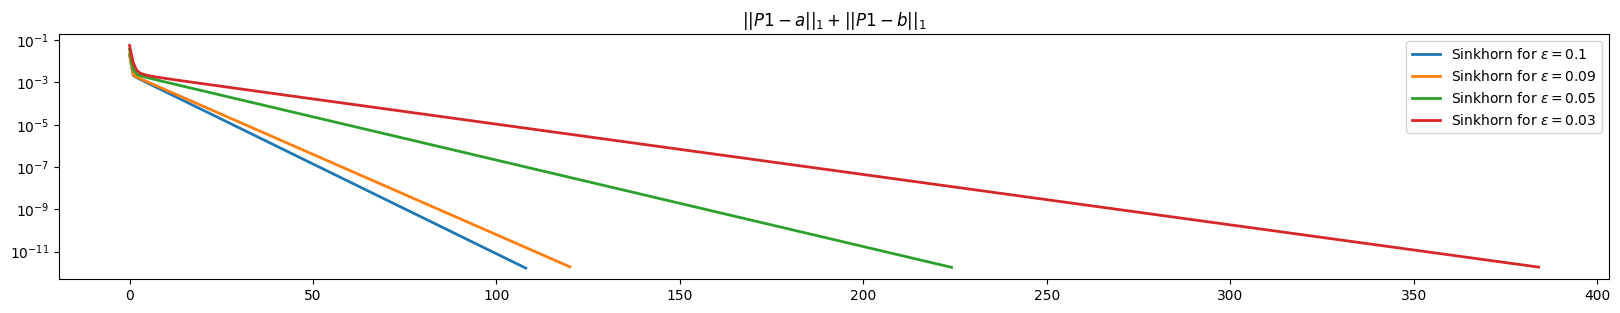

In [18]:
plt.figure( figsize = (20,7) )

plt.subplot(2,1,1),
plt.title( "$||P1 -a||_1+||P1 -b||_1$" )
for i in range( len(results_Sinkhorn) ):
  error=np.asarray( results_Sinkhorn[i]['error_a'] )+np.asarray( results_Sinkhorn[i]['error_b'] )
  plt.plot( error,label='Sinkhorn for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )
plt.yscale( 'log' )
plt.legend()

plt.savefig("DampedNewtonVsSinkhorn_benchmark_annulusVSsquare_images/ConvergenceSinkhornvaryingepsilonL2.png")
plt.show()

## Damped Newton without preconditioning


In [19]:
rho = 0.95
c = 0.05
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []
Hessians_DampedNewton = []

for eps in epsilons:
    # Line Search
    print( "Damped Newton for epsilon = "+str(eps)+":" )    
    #Cost matrix
    C = p_norms(x,y,2)

    # a and b
    a = normalize( np.ones( N[0] ) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones( N[1] ) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)
    f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton( K,a,b,f,g,eps,rho,c )
    out = Optimizer._update( maxiter=50 )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append( end-start )
    print( " |- Computing P" )
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    print( " |- Recording (unstabilized) Hessian \n" )

    mat  = -eps*Optimizer.Hessian
    diag = 1/np.sqrt( np.vstack( (a,b) ) ).flatten()
    mat = diag[:,None]*mat*diag[None,:]
    Hessians_DampedNewton.append( mat )
    

Damped Newton for epsilon = 0.1:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  18
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.09:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.05:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  15
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.03:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  18
 |- Computing P
 |- Recording (unstabilized) Hessian 



In [20]:
eigs = []
eigvecs = []
for i in range( len(epsilons) ) :
    eps = epsilons[i]
    print( "Spectral statistics of Hessian for epsilon="+str(eps) )
    ev = spectral_decomposition( Hessians_DampedNewton[i] )
    eigs.append( ev[0] )
    eigvecs.append( ev[1] )
    print("")


Spectral statistics of Hessian for epsilon=0.1
List of smallest eigenvalues:  [2.75320986e-16 9.30751454e-02 9.52516072e-02 2.47829727e-01
 3.33857315e-01 4.97953654e-01 5.05001611e-01 6.56881804e-01
 6.95308767e-01 8.00721211e-01]
List of largest  eigenvalues:  [1.19927879 1.30469123 1.3431182  1.49499839 1.50204635 1.66614268
 1.75217027 1.90474839 1.90692485 2.        ]

Spectral statistics of Hessian for epsilon=0.09
List of smallest eigenvalues:  [7.68825532e-16 8.37218255e-02 8.57957702e-02 2.26988575e-01
 3.06904492e-01 4.64416855e-01 4.71001023e-01 6.20883352e-01
 6.60737923e-01 7.69731853e-01]
List of largest  eigenvalues:  [1.23026815 1.33926208 1.37911665 1.52899898 1.53558315 1.69309551
 1.77301143 1.91420423 1.91627818 2.        ]

Spectral statistics of Hessian for epsilon=0.05
List of smallest eigenvalues:  [-2.99186634e-16  4.59428220e-02  4.78494193e-02  1.36543501e-01
  1.85948710e-01  3.01551383e-01  3.05217481e-01  4.26310808e-01
  4.68018847e-01  5.75250594e-01]
Li

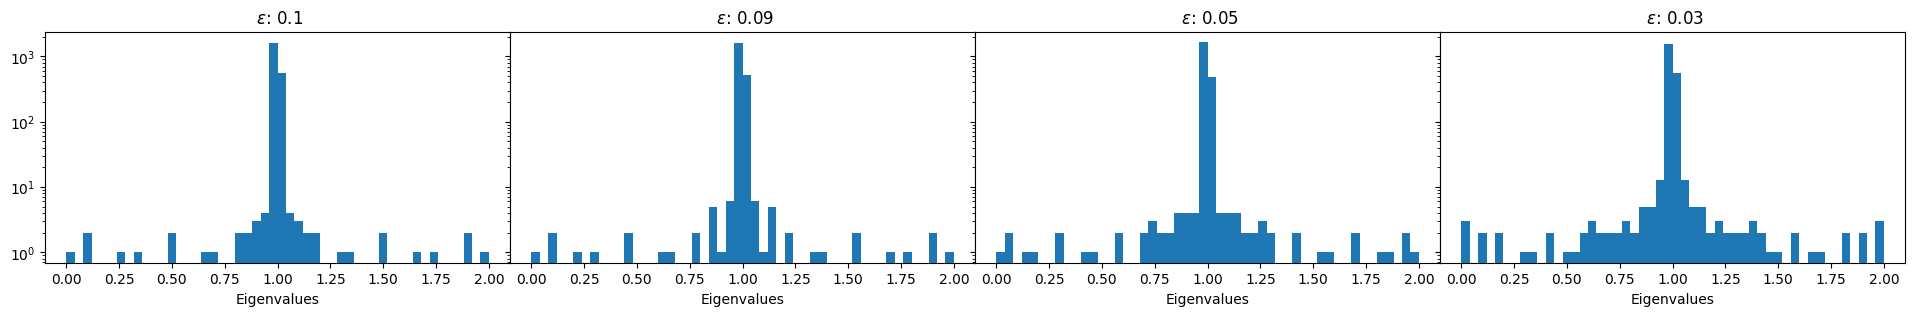

In [21]:
fig,ax = plt.subplots( figsize=(24,3),nrows=1, ncols=len(epsilons), sharey=True )
plt.title( "Histogram of eigenvalues." )
for i in range( len(epsilons) ):
    ax[i].hist( eigs[i], 50 )
    ax[i].set_title( " $\epsilon$: "+str(epsilons[i]) )
    ax[i].set_xlabel( "Eigenvalues" )
    ax[i].set_yscale( "log" )
plt.subplots_adjust( wspace=0,hspace=0 )
plt.savefig("DampedNewtonVsSinkhorn_benchmark_annulusVSsquare_images/eigenhistunstabilizedL2.png")
plt.show()

In [22]:
num_eigs = 10
null_vector, precond_vectors = build_preconditioners( num_eigs, Hessians_DampedNewton[-1],N, ansatz=False )

## Damped Newton with preconditioning

In [23]:
rho = 0.95
c = 0.05
reset_starting_point = True
final_modified_Hessians = []
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []

#epsilons = [ 0.3 ]
f, g = None, None
for eps in epsilons:
    # Line Search
    print( "Damped Newton for epsilon="+str(eps)+":" )    
    # Cost matrix
    C = p_norms(x,y,2)

    # a and b
    a = normalize( np.ones(N[0]) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones(N[1]) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)

    if (f is None) or (g is None): 
        f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton_With_Preconditioner( K,a,b,f,g,eps,rho,c,null_vector,precond_vectors[:] )
    out = Optimizer._update( maxiter=50, iterative_inversion=30, version=None,debug=False,optType='cg' )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P" )

    if not reset_starting_point:
        f = Optimizer.x[:a.shape[0]]
        g = Optimizer.x[a.shape[0]:]
        # f = f.reshape( f.shape[0], -1)
        # g = g.reshape( g.shape[0], -1)
    
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    final_modified_Hessians.append( Optimizer.modified_Hessian )


Damped Newton for epsilon=0.1:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  28
 |- Computing P
Damped Newton for epsilon=0.09:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  29
 |- Computing P
Damped Newton for epsilon=0.05:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  29
 |- Computing P
Damped Newton for epsilon=0.03:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  23
 |- Computing P


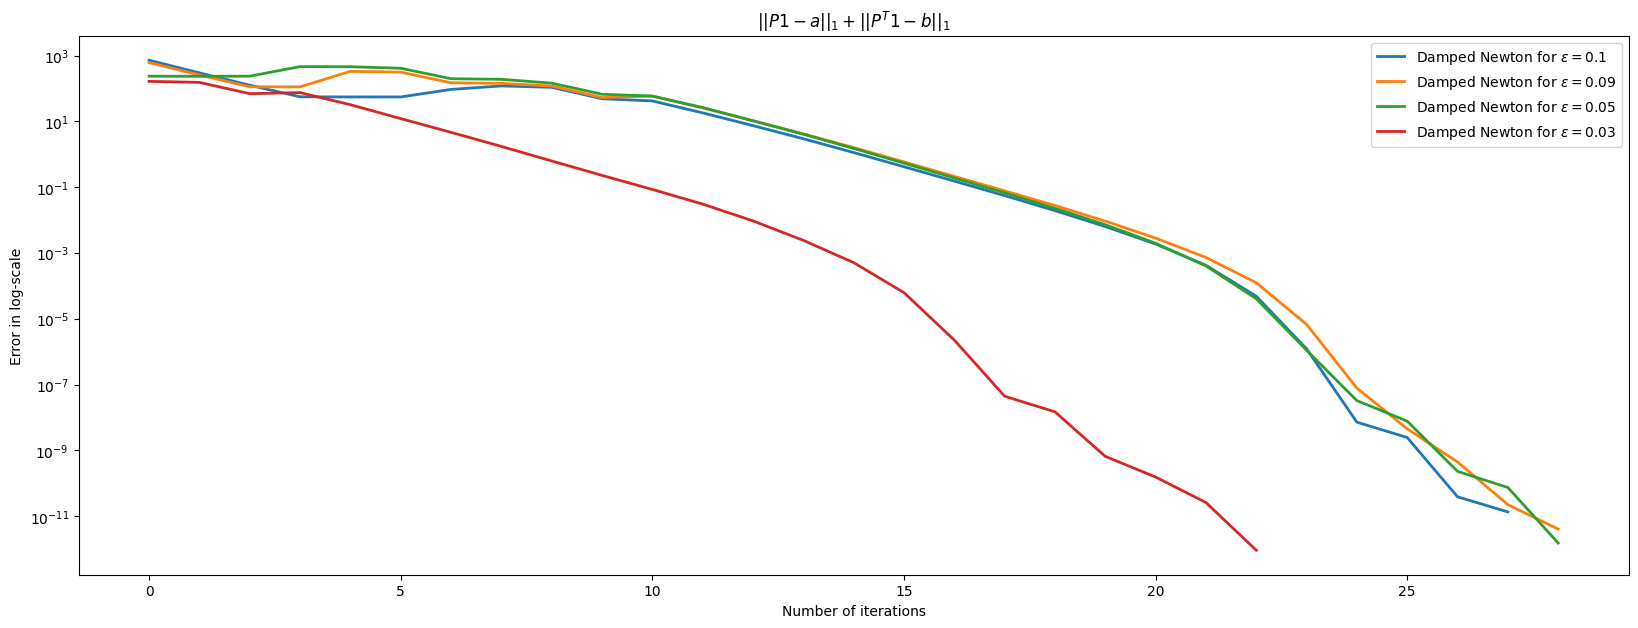


 Error plots can increase! The error is not the objective function!


In [24]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" )

for i in range( len(results_DampedNewton) ):
  error = np.asarray( results_DampedNewton[i]['error_a'] )+np.asarray( results_DampedNewton[i]['error_b'] )
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.savefig( "DampedNewtonVsSinkhorn_benchmark_annulusVSsquare_images/ErrorLinesearchNewton_final_cgL2.png" )
plt.show()
print( "\n Error plots can increase! The error is not the objective function!" )

# L4-norm

## Sinkhorn

In [25]:
print("Sinkhorn.... ")
SinkhornP=[]
results_Sinkhorn=[]
times_Sinkhorn=[]
for eps in epsilons:

  
  #Cost matrix
  C = p_norms(x,y,4)
  
  # a and b
  a = normalize(np.ones(N[0]))
  a = a.reshape(a.shape[0],-1)
  b = normalize(np.ones(N[1]))
  b = b.reshape(b.shape[0],-1)



  #Kernel
  K = np.exp(-C/eps)


  print( "Doing for (",N[0],N[1],") and epsilon = " +str(eps)+ " ." )
  print( " |- Iterating" )

  #Inflating
  u = a
  v = b

  start = time.time()
  Optimizer = computational_OT.Sinkhorn( K,a,b,u,v,eps)
  out = Optimizer._update(maxiter=10000)
  results_Sinkhorn.append( out )
  end = time.time()
  times_Sinkhorn.append( end-start )
  print( " |- Computing P" )
  print( "" )
  SinkhornP.append(GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)))
  

Sinkhorn.... 
Doing for ( 1000 1200 ) and epsilon = 0.1 .
 |- Iterating
Terminating after iteration:  53
 |- Computing P

Doing for ( 1000 1200 ) and epsilon = 0.09 .
 |- Iterating
Terminating after iteration:  58
 |- Computing P

Doing for ( 1000 1200 ) and epsilon = 0.05 .
 |- Iterating
Terminating after iteration:  102
 |- Computing P

Doing for ( 1000 1200 ) and epsilon = 0.03 .
 |- Iterating
Terminating after iteration:  171
 |- Computing P



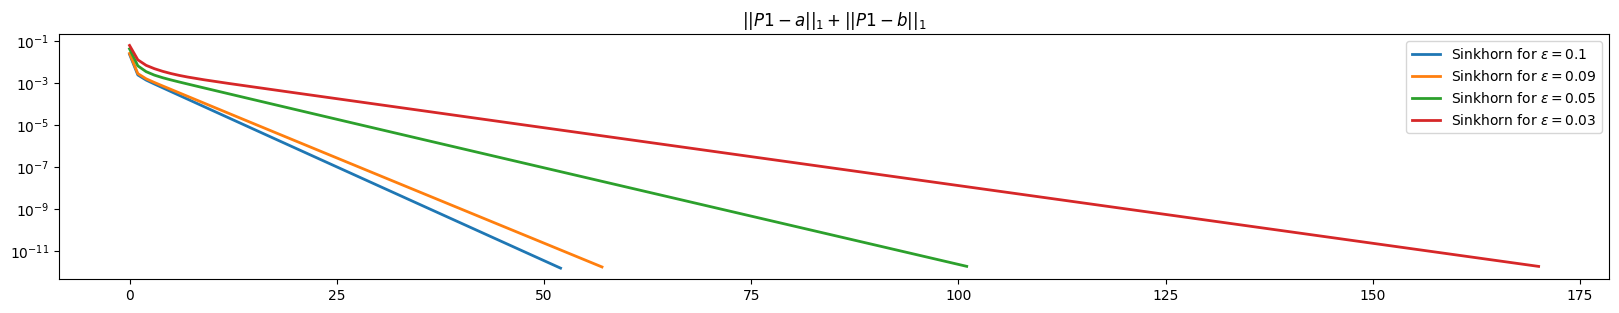

In [26]:
plt.figure( figsize = (20,7) )

plt.subplot(2,1,1),
plt.title( "$||P1 -a||_1+||P1 -b||_1$" )
for i in range( len(results_Sinkhorn) ):
  error=np.asarray( results_Sinkhorn[i]['error_a'] )+np.asarray( results_Sinkhorn[i]['error_b'] )
  plt.plot( error,label='Sinkhorn for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )
plt.yscale( 'log' )
plt.legend()

plt.savefig("DampedNewtonVsSinkhorn_benchmark_annulusVSsquare_images/ConvergenceSinkhornvaryingepsilonL4.png")
plt.show()

## Damped Newton without preconditioning

In [27]:
rho = 0.95
c = 0.05
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []
Hessians_DampedNewton = []

for eps in epsilons:
    # Line Search
    print( "Damped Newton for epsilon = "+str(eps)+":" )    
    #Cost matrix
    C = p_norms(x,y,4)

    # a and b
    a = normalize( np.ones( N[0] ) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones( N[1] ) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)
    f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton( K,a,b,f,g,eps,rho,c )
    out = Optimizer._update( maxiter=50 )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append( end-start )
    print( " |- Computing P" )
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    print( " |- Recording (unstabilized) Hessian \n" )

    mat  = -eps*Optimizer.Hessian
    diag = 1/np.sqrt( np.vstack( (a,b) ) ).flatten()
    mat = diag[:,None]*mat*diag[None,:]
    Hessians_DampedNewton.append( mat )
    

Damped Newton for epsilon = 0.1:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  15
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.09:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  15
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.05:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  17
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.03:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  2
 |- Computing P
 |- Recording (unstabilized) Hessian 



In [28]:
eigs = []
eigvecs = []
for i in range( len(epsilons) ) :
    eps = epsilons[i]
    print( "Spectral statistics of Hessian for epsilon="+str(eps) )
    ev = spectral_decomposition( Hessians_DampedNewton[i] )
    eigs.append( ev[0] )
    eigvecs.append( ev[1] )
    print("")


Spectral statistics of Hessian for epsilon=0.1
List of smallest eigenvalues:  [4.31802485e-16 1.85710821e-01 2.01182920e-01 4.20308297e-01
 5.37022363e-01 5.83179568e-01 6.04065912e-01 6.09207554e-01
 7.10248960e-01 7.29130060e-01]
List of largest  eigenvalues:  [1.27087126 1.28975317 1.39079748 1.39593706 1.41682327 1.46298076
 1.57969333 1.79881979 1.81429174 2.00000299]

Spectral statistics of Hessian for epsilon=0.09
List of smallest eigenvalues:  [1.99788434e-16 1.70241405e-01 1.85421309e-01 3.86500300e-01
 5.03586219e-01 5.46920184e-01 5.68042500e-01 5.77774977e-01
 6.73560826e-01 6.93756188e-01]
List of largest  eigenvalues:  [1.306244   1.32643941 1.42222567 1.43195788 1.45308016 1.49641417
 1.61349987 1.81457901 1.82975889 2.00000035]

Spectral statistics of Hessian for epsilon=0.05
List of smallest eigenvalues:  [3.06469404e-16 1.00414663e-01 1.11787164e-01 2.25625667e-01
 3.19408854e-01 3.46246654e-01 3.67455841e-01 3.98960395e-01
 4.42608070e-01 4.57165625e-01]
List of larg

The eigenvalues for 0.03 contains Nans.


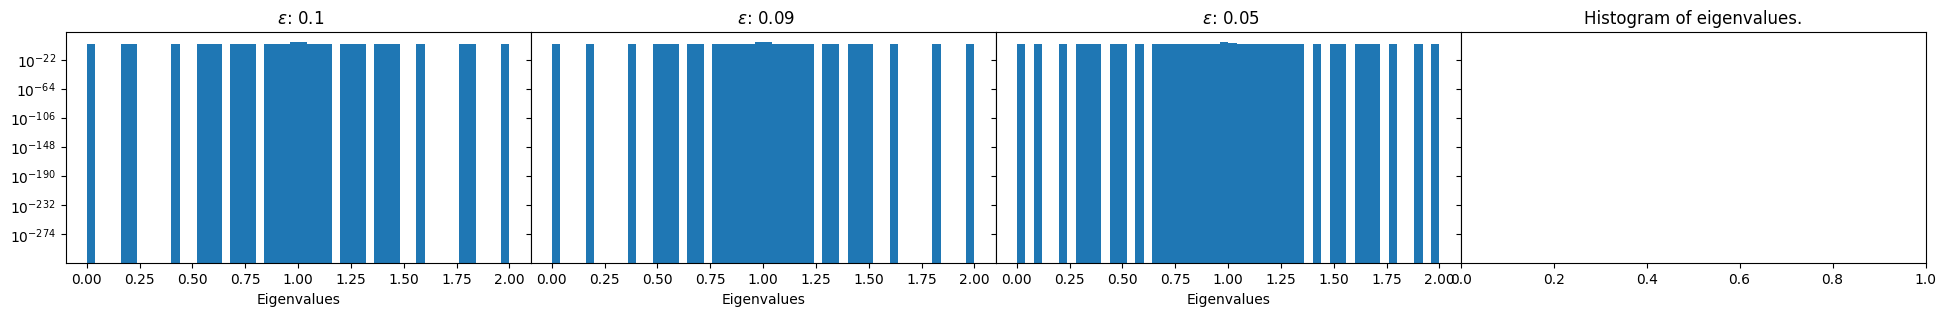

In [29]:
fig,ax = plt.subplots( figsize=(24,3),nrows=1, ncols=len(epsilons), sharey=True )
plt.title( "Histogram of eigenvalues." )
for i in range( len(epsilons) ):
    if not np.isnan(eigs[i]).any():
        ax[i].hist( eigs[i], 50 )
        ax[i].set_title( " $\epsilon$: "+str(epsilons[i]) )
        ax[i].set_xlabel( "Eigenvalues" )
        ax[i].set_yscale( "log" )
    
    else:
        print("The eigenvalues for "+str(epsilons[i])+ " contains Nans.")
plt.subplots_adjust( wspace=0,hspace=0 )
plt.savefig("DampedNewtonVsSinkhorn_benchmark_annulusVSsquare_images/eigenhistunstabilizedL2.png")
plt.show()

In [30]:
num_eigs = 10
null_vector, precond_vectors = build_preconditioners( num_eigs, Hessians_DampedNewton[-1],N, ansatz=False )

## Damped Newton with preconditioning

In [31]:
rho = 0.95
c = 0.05
reset_starting_point = True
final_modified_Hessians = []
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []

#epsilons = [ 0.3 ]
f, g = None, None
for eps in epsilons:
    # Line Search
    print( "Damped Newton for epsilon="+str(eps)+":" )    
    # Cost matrix
    C = p_norms(x,y,4)

    # a and b
    a = normalize( np.ones(N[0]) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones(N[1]) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)

    if (f is None) or (g is None): 
        f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton_With_Preconditioner( K,a,b,f,g,eps,rho,c,null_vector,precond_vectors[:] )
    out = Optimizer._update( maxiter=50, iterative_inversion=30, version=None,debug=False,optType='cg' )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P" )

    if not reset_starting_point:
        f = Optimizer.x[:a.shape[0]]
        g = Optimizer.x[a.shape[0]:]
        # f = f.reshape( f.shape[0], -1)
        # g = g.reshape( g.shape[0], -1)
    
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    final_modified_Hessians.append( Optimizer.modified_Hessian )


Damped Newton for epsilon=0.1:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  1
 |- Computing P
Damped Newton for epsilon=0.09:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  1
 |- Computing P
Damped Newton for epsilon=0.05:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  1
 |- Computing P
Damped Newton for epsilon=0.03:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  1
 |- Computing P


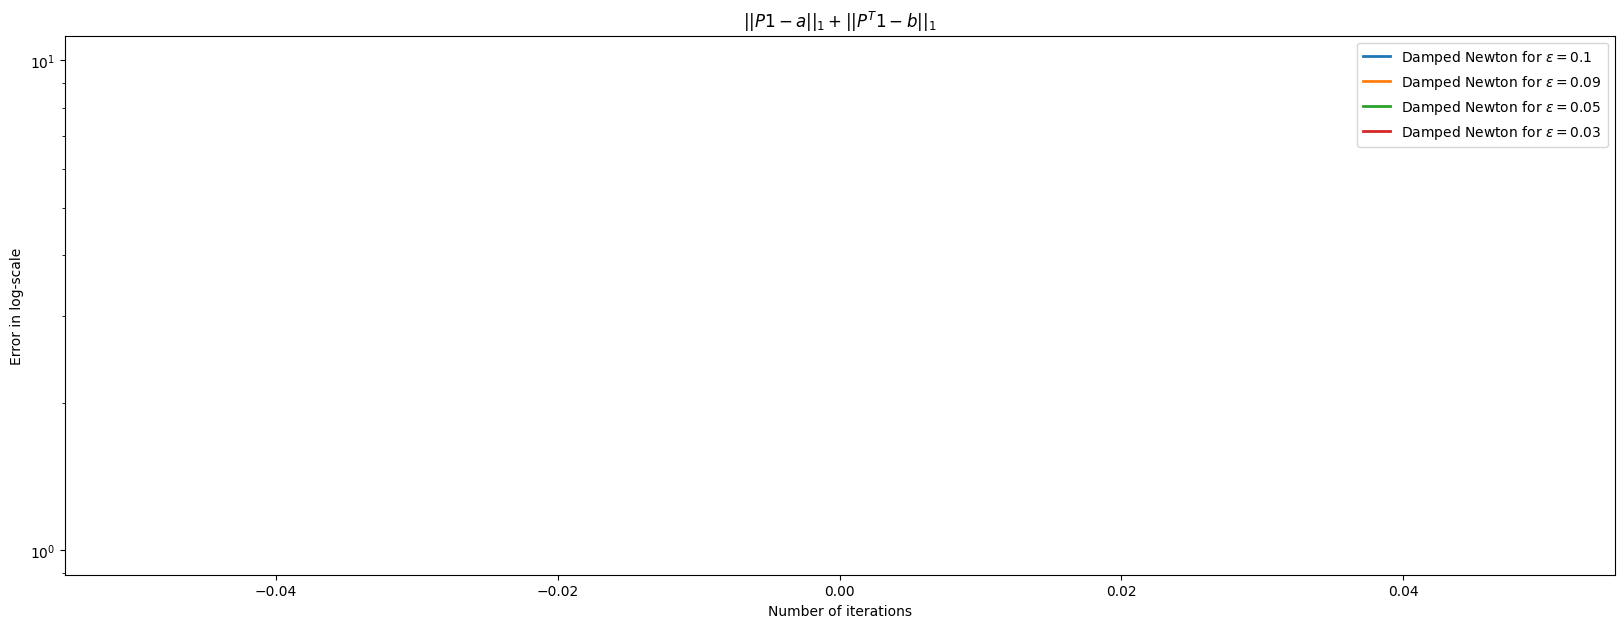


 Error plots can increase! The error is not the objective function!


In [32]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" )

for i in range( len(results_DampedNewton) ):
  error = np.asarray( results_DampedNewton[i]['error_a'] )+np.asarray( results_DampedNewton[i]['error_b'] )
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.savefig( "DampedNewtonVsSinkhorn_benchmark_annulusVSsquare_images/ErrorLinesearchNewton_final_cgL2.png" )
plt.show()
print( "\n Error plots can increase! The error is not the objective function!" )

# L-infinity

## Sinkhorn

In [33]:
print("Sinkhorn.... ")
SinkhornP=[]
results_Sinkhorn=[]
times_Sinkhorn=[]
for eps in epsilons:

  
  #Cost matrix
  C = p_norms(x,y,'inf')
  
  # a and b
  a = normalize(np.ones(N[0]))
  a = a.reshape(a.shape[0],-1)
  b = normalize(np.ones(N[1]))
  b = b.reshape(b.shape[0],-1)



  #Kernel
  K = np.exp(-C/eps)


  print( "Doing for (",N[0],N[1],") and epsilon = " +str(eps)+ " ." )
  print( " |- Iterating" )

  #Inflating
  u = a
  v = b

  start = time.time()
  Optimizer = computational_OT.Sinkhorn( K,a,b,u,v,eps)
  out = Optimizer._update(maxiter=10000)
  results_Sinkhorn.append( out )
  end = time.time()
  times_Sinkhorn.append( end-start )
  print( " |- Computing P" )
  print( "" )
  SinkhornP.append(GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)))
  

Sinkhorn.... 
Doing for ( 1000 1200 ) and epsilon = 0.1 .
 |- Iterating
Terminating after iteration:  61
 |- Computing P

Doing for ( 1000 1200 ) and epsilon = 0.09 .
 |- Iterating
Terminating after iteration:  69
 |- Computing P

Doing for ( 1000 1200 ) and epsilon = 0.05 .
 |- Iterating
Terminating after iteration:  133
 |- Computing P

Doing for ( 1000 1200 ) and epsilon = 0.03 .
 |- Iterating
Terminating after iteration:  238
 |- Computing P



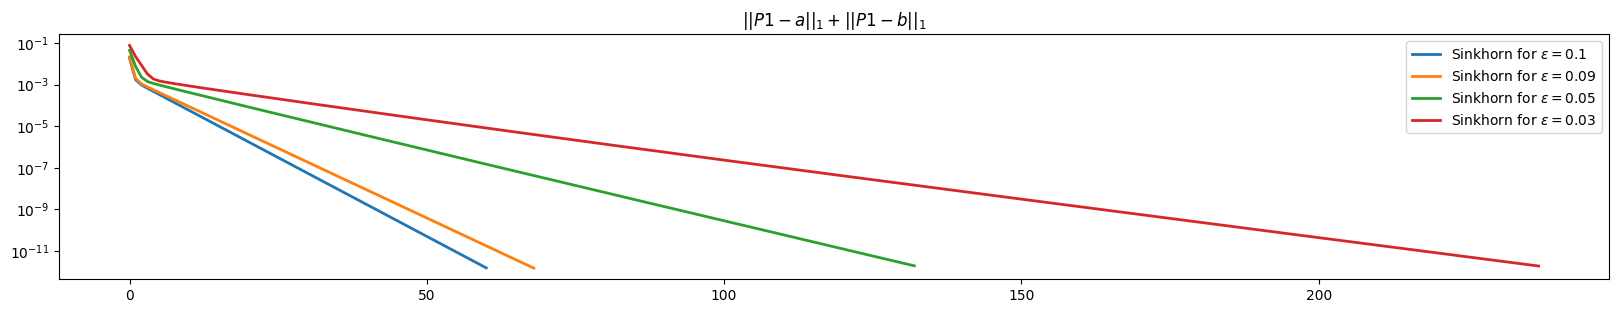

In [34]:
plt.figure( figsize = (20,7) )

plt.subplot(2,1,1),
plt.title( "$||P1 -a||_1+||P1 -b||_1$" )
for i in range( len(results_Sinkhorn) ):
  error=np.asarray( results_Sinkhorn[i]['error_a'] )+np.asarray( results_Sinkhorn[i]['error_b'] )
  plt.plot( error,label='Sinkhorn for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )
plt.yscale( 'log' )
plt.legend()

plt.savefig("DampedNewtonVsSinkhorn_benchmark_annulusVSsquare_images/ConvergenceSinkhornvaryingepsilonL4.png")
plt.show()

## Damped Newton without preconditioning

In [35]:
rho = 0.95
c = 0.05
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []
Hessians_DampedNewton = []

for eps in epsilons:
    # Line Search
    print( "Damped Newton for epsilon = "+str(eps)+":" )    
    #Cost matrix
    C = p_norms(x,y,'inf')

    # a and b
    a = normalize( np.ones( N[0] ) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones( N[1] ) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)
    f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton( K,a,b,f,g,eps,rho,c )
    out = Optimizer._update( maxiter=50 )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append( end-start )
    print( " |- Computing P" )
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    print( " |- Recording (unstabilized) Hessian \n" )

    mat  = -eps*Optimizer.Hessian
    diag = 1/np.sqrt( np.vstack( (a,b) ) ).flatten()
    mat = diag[:,None]*mat*diag[None,:]
    Hessians_DampedNewton.append( mat )
    

Damped Newton for epsilon = 0.1:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  14
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.09:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  14
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.05:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  12
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.03:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  14
 |- Computing P
 |- Recording (unstabilized) Hessian 



In [36]:
eigs = []
eigvecs = []
for i in range( len(epsilons) ) :
    eps = epsilons[i]
    print( "Spectral statistics of Hessian for epsilon="+str(eps) )
    ev = spectral_decomposition( Hessians_DampedNewton[i] )
    eigs.append( ev[0] )
    eigvecs.append( ev[1] )
    print("")


Spectral statistics of Hessian for epsilon=0.1
List of smallest eigenvalues:  [1.18917806e-16 1.60245801e-01 1.66780498e-01 3.66187255e-01
 4.59801920e-01 6.12673707e-01 6.18581813e-01 7.16059440e-01
 7.46744753e-01 8.05927531e-01]
List of largest  eigenvalues:  [1.19407269 1.25325537 1.28394086 1.38141845 1.38732662 1.54019853
 1.6338128  1.83321967 1.83975435 2.00000017]

Spectral statistics of Hessian for epsilon=0.09
List of smallest eigenvalues:  [7.86633794e-16 1.43016820e-01 1.49421955e-01 3.28833091e-01
 4.41554315e-01 5.85041325e-01 5.91302995e-01 6.90118811e-01
 7.21222150e-01 7.84095497e-01]
List of largest  eigenvalues:  [1.21590452 1.27877786 1.30988121 1.40869702 1.4149587  1.55844572
 1.67116691 1.85057806 1.85698319 2.00000001]

Spectral statistics of Hessian for epsilon=0.05
List of smallest eigenvalues:  [-8.79984111e-17  7.48565108e-02  8.13264583e-02  1.75126145e-01
  3.64023292e-01  4.58385137e-01  4.67759445e-01  5.54638460e-01
  5.93360090e-01  6.63600514e-01]
Li

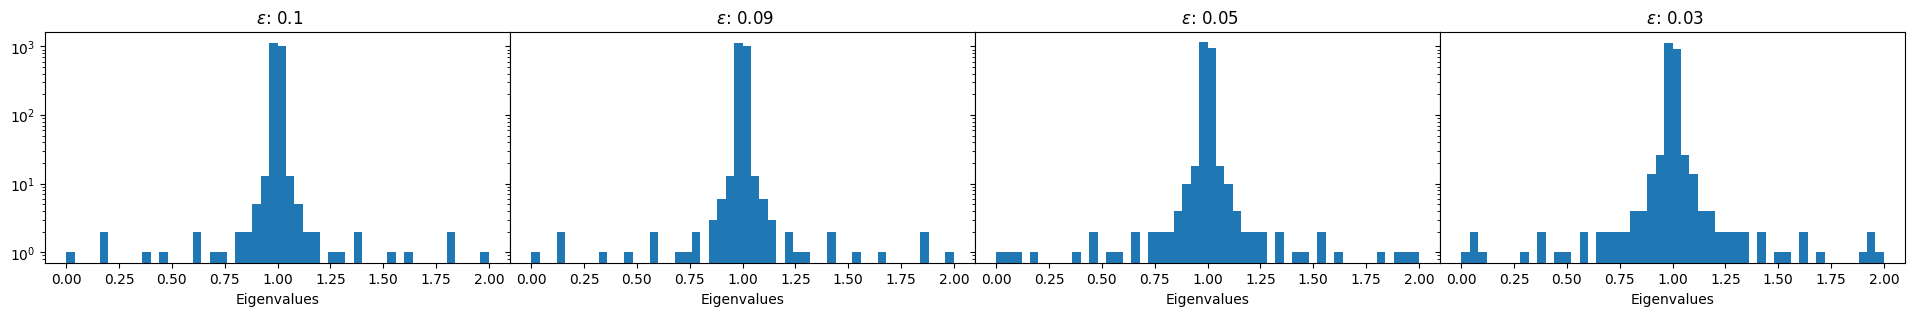

In [37]:
fig,ax = plt.subplots( figsize=(24,3),nrows=1, ncols=len(epsilons), sharey=True )
plt.title( "Histogram of eigenvalues." )
for i in range( len(epsilons) ):
    ax[i].hist( eigs[i], 50 )
    ax[i].set_title( " $\epsilon$: "+str(epsilons[i]) )
    ax[i].set_xlabel( "Eigenvalues" )
    ax[i].set_yscale( "log" )
plt.subplots_adjust( wspace=0,hspace=0 )
plt.savefig("DampedNewtonVsSinkhorn_benchmark_annulusVSsquare_images/eigenhistunstabilizedL2.png")
plt.show()

## Damped Newton with preconditioning

In [38]:
num_eigs = 10
null_vector, precond_vectors = build_preconditioners( num_eigs, Hessians_DampedNewton[-1],N, ansatz=False )

In [39]:
rho = 0.95
c = 0.05
reset_starting_point = True
final_modified_Hessians = []
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []

#epsilons = [ 0.3 ]
f, g = None, None
for eps in epsilons:
    # Line Search
    print( "Damped Newton for epsilon="+str(eps)+":" )    
    # Cost matrix
    C = p_norms(x,y,'inf')

    # a and b
    a = normalize( np.ones(N[0]) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones(N[1]) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)

    if (f is None) or (g is None): 
        f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton_With_Preconditioner( K,a,b,f,g,eps,rho,c,null_vector,precond_vectors[:] )
    out = Optimizer._update( maxiter=50, iterative_inversion=30, version=None,debug=False,optType='cg' )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P" )

    if not reset_starting_point:
        f = Optimizer.x[:a.shape[0]]
        g = Optimizer.x[a.shape[0]:]
        # f = f.reshape( f.shape[0], -1)
        # g = g.reshape( g.shape[0], -1)
    
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    final_modified_Hessians.append( Optimizer.modified_Hessian )


Damped Newton for epsilon=0.1:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  17
 |- Computing P
Damped Newton for epsilon=0.09:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  18
 |- Computing P
Damped Newton for epsilon=0.05:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P
Damped Newton for epsilon=0.03:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P


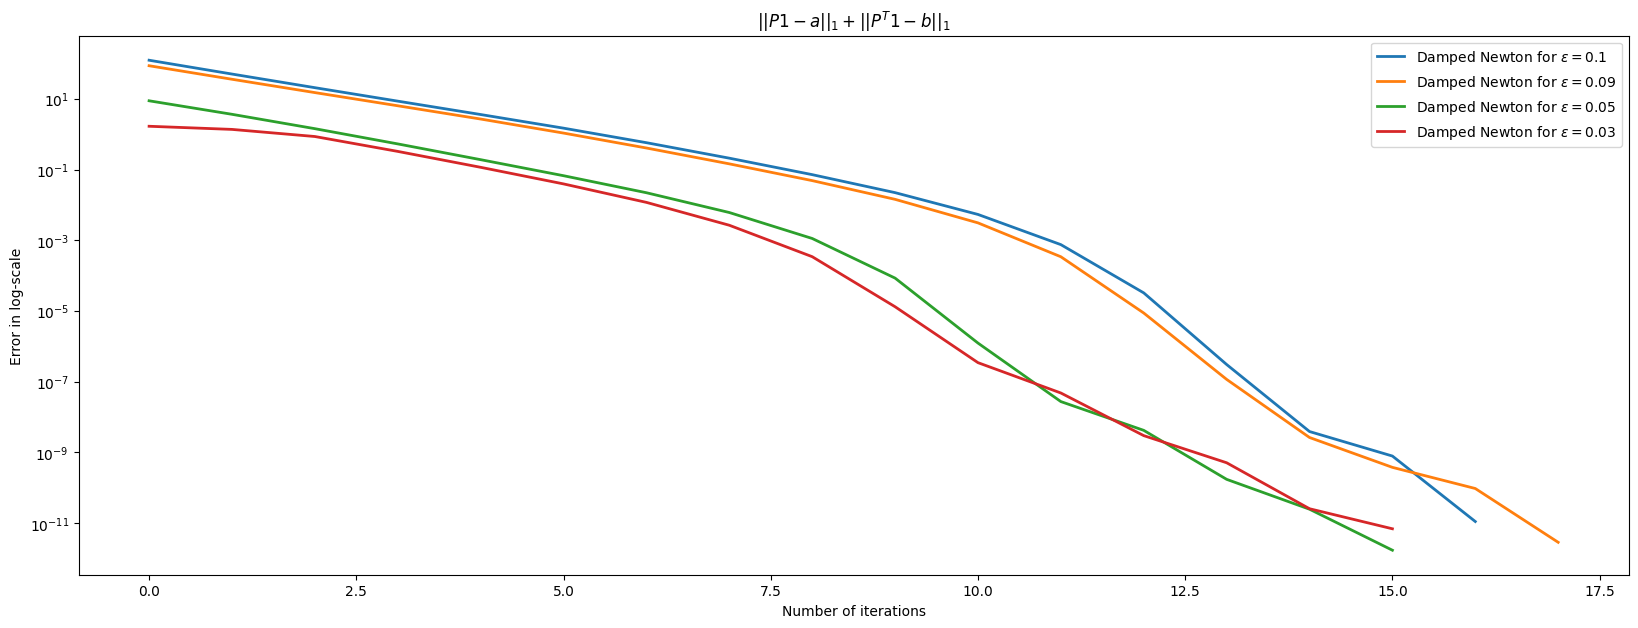


 Error plots can increase! The error is not the objective function!


In [40]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" )

for i in range( len(results_DampedNewton) ):
  error = np.asarray( results_DampedNewton[i]['error_a'] )+np.asarray( results_DampedNewton[i]['error_b'] )
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.savefig( "DampedNewtonVsSinkhorn_benchmark_annulusVSsquare_images/ErrorLinesearchNewton_final_cgL2.png" )
plt.show()
print( "\n Error plots can increase! The error is not the objective function!" )

# 1-cosine similarity

## Sinkhorn

In [42]:
print("Sinkhorn.... ")
SinkhornP=[]
results_Sinkhorn=[]
times_Sinkhorn=[]
for eps in epsilons:

  
  #Cost matrix
  C =1- (x.transpose().dot(y))/(np.linalg.norm(x,2)*np.linalg.norm(y,2))
  
  # a and b
  a = normalize(np.ones(N[0]))
  a = a.reshape(a.shape[0],-1)
  b = normalize(np.ones(N[1]))
  b = b.reshape(b.shape[0],-1)



  #Kernel
  K = np.exp(-C/eps)


  print( "Doing for (",N[0],N[1],") and epsilon = " +str(eps)+ " ." )
  print( " |- Iterating" )

  #Inflating
  u = a
  v = b

  start = time.time()
  Optimizer = computational_OT.Sinkhorn( K,a,b,u,v,eps)
  out = Optimizer._update(maxiter=10000)
  results_Sinkhorn.append( out )
  end = time.time()
  times_Sinkhorn.append( end-start )
  print( " |- Computing P" )
  print( "" )
  SinkhornP.append(GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)))
  

Sinkhorn.... 
Doing for ( 1000 1200 ) and epsilon = 0.1 .
 |- Iterating
Terminating after iteration:  3
 |- Computing P

Doing for ( 1000 1200 ) and epsilon = 0.09 .
 |- Iterating
Terminating after iteration:  3
 |- Computing P

Doing for ( 1000 1200 ) and epsilon = 0.05 .
 |- Iterating
Terminating after iteration:  4
 |- Computing P

Doing for ( 1000 1200 ) and epsilon = 0.03 .
 |- Iterating
Terminating after iteration:  4
 |- Computing P



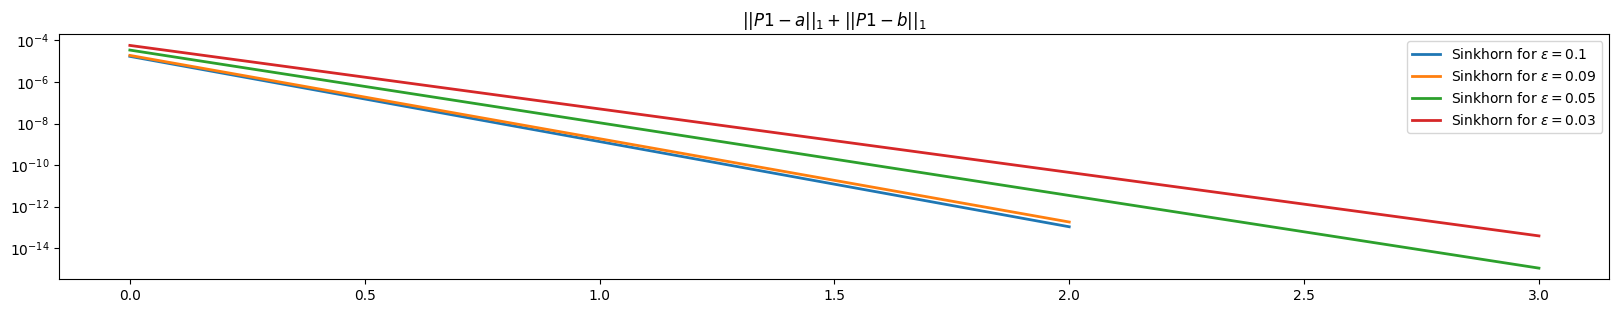

In [43]:

plt.figure( figsize = (20,7) )

plt.subplot(2,1,1),
plt.title( "$||P1 -a||_1+||P1 -b||_1$" )
for i in range( len(results_Sinkhorn) ):
  error=np.asarray( results_Sinkhorn[i]['error_a'] )+np.asarray( results_Sinkhorn[i]['error_b'] )
  plt.plot( error,label='Sinkhorn for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )
plt.yscale( 'log' )
plt.legend()

plt.savefig("DampedNewtonVsSinkhorn_benchmark_annulusVSsquare_images/ConvergenceSinkhornvaryingepsilonL4.png")
plt.show()

## Damped Newton without preconditioning

In [44]:
rho = 0.95
c = 0.05
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []
Hessians_DampedNewton = []

for eps in epsilons:
    # Line Search
    print( "Damped Newton for epsilon = "+str(eps)+":" )    
    #Cost matrix
    C =1- (x.transpose().dot(y))/(np.linalg.norm(x,2)*np.linalg.norm(y,2))

    # a and b
    a = normalize( np.ones( N[0] ) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones( N[1] ) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)
    f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton( K,a,b,f,g,eps,rho,c )
    out = Optimizer._update( maxiter=50 )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append( end-start )
    print( " |- Computing P" )
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    print( " |- Recording (unstabilized) Hessian \n" )

    mat  = -eps*Optimizer.Hessian
    diag = 1/np.sqrt( np.vstack( (a,b) ) ).flatten()
    mat = diag[:,None]*mat*diag[None,:]
    Hessians_DampedNewton.append( mat )
    

Damped Newton for epsilon = 0.1:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  10
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.09:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  7
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.05:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  7
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.03:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  11
 |- Computing P
 |- Recording (unstabilized) Hessian 



In [45]:
eigs = []
eigvecs = []
for i in range( len(epsilons) ) :
    eps = epsilons[i]
    print( "Spectral statistics of Hessian for epsilon="+str(eps) )
    ev = spectral_decomposition( Hessians_DampedNewton[i] )
    eigs.append( ev[0] )
    eigvecs.append( ev[1] )
    print("")


Spectral statistics of Hessian for epsilon=0.1
List of smallest eigenvalues:  [5.55111512e-16 9.90985577e-01 9.91145490e-01 9.99942472e-01
 9.99965506e-01 9.99993951e-01 9.99999831e-01 9.99999841e-01
 9.99999979e-01 9.99999980e-01]
List of largest  eigenvalues:  [1.00000002 1.00000002 1.00000016 1.00000017 1.00000605 1.00003449
 1.00005753 1.00885451 1.00901442 2.        ]

Spectral statistics of Hessian for epsilon=0.09
List of smallest eigenvalues:  [-4.99603079e-16  9.89989442e-01  9.90167096e-01  9.99934349e-01
  9.99962784e-01  9.99997903e-01  1.00000514e+00  1.00000515e+00
  1.00000532e+00  1.00000532e+00]
List of largest  eigenvalues:  [1.00000543 1.00000543 1.00000559 1.0000056  1.00001284 1.00004796
 1.00007639 1.00984364 1.0100213  2.00001074]

Spectral statistics of Hessian for epsilon=0.05
List of smallest eigenvalues:  [-1.11022757e-16  9.81977771e-01  9.82297135e-01  9.99773301e-01
  9.99865420e-01  9.99979170e-01  1.00000199e+00  1.00000206e+00
  1.00000287e+00  1.000002

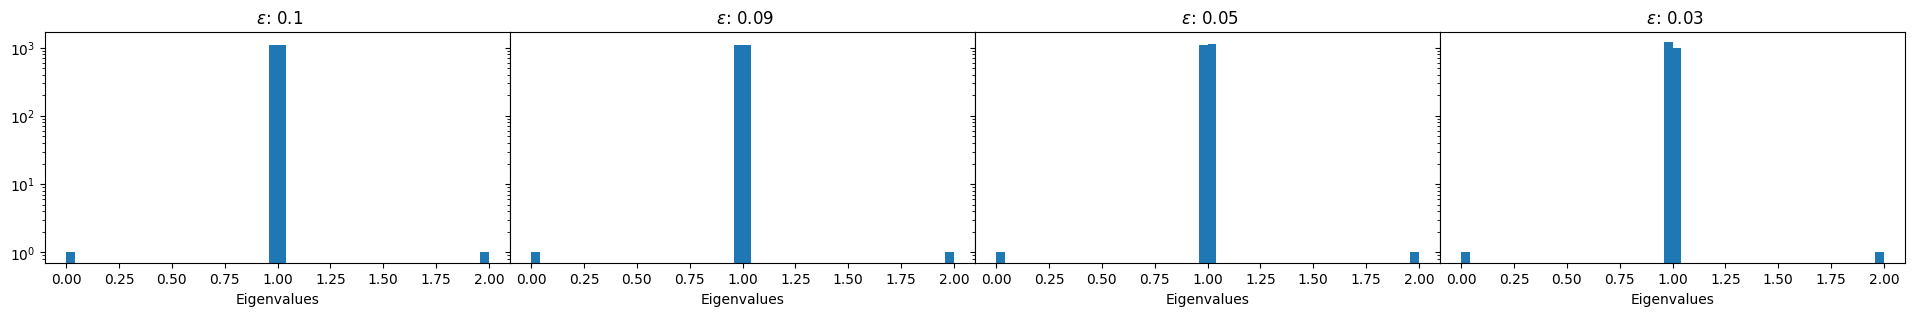

In [46]:
fig,ax = plt.subplots( figsize=(24,3),nrows=1, ncols=len(epsilons), sharey=True )
plt.title( "Histogram of eigenvalues." )
for i in range( len(epsilons) ):
    ax[i].hist( eigs[i], 50 )
    ax[i].set_title( " $\epsilon$: "+str(epsilons[i]) )
    ax[i].set_xlabel( "Eigenvalues" )
    ax[i].set_yscale( "log" )
plt.subplots_adjust( wspace=0,hspace=0 )
plt.savefig("DampedNewtonVsSinkhorn_benchmark_annulusVSsquare_images/eigenhistunstabilizedL2.png")
plt.show()

## Damped Newton with preconditioning

In [47]:
num_eigs = 10
null_vector, precond_vectors = build_preconditioners( num_eigs, Hessians_DampedNewton[-1],N, ansatz=False )

In [48]:
rho = 0.95
c = 0.05
reset_starting_point = True
final_modified_Hessians = []
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []

#epsilons = [ 0.3 ]
f, g = None, None
for eps in epsilons:
    # Line Search
    print( "Damped Newton for epsilon="+str(eps)+":" )    
    # Cost matrix
    C =1- (x.transpose().dot(y))/(np.linalg.norm(x,2)*np.linalg.norm(y,2))

    # a and b
    a = normalize( np.ones(N[0]) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones(N[1]) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/eps)

    if (f is None) or (g is None): 
        f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewton_With_Preconditioner( K,a,b,f,g,eps,rho,c,null_vector,precond_vectors[:] )
    out = Optimizer._update( maxiter=50, iterative_inversion=30, version=None,debug=False,optType='cg' )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P" )

    if not reset_starting_point:
        f = Optimizer.x[:a.shape[0]]
        g = Optimizer.x[a.shape[0]:]
        # f = f.reshape( f.shape[0], -1)
        # g = g.reshape( g.shape[0], -1)
    
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)) )
    final_modified_Hessians.append( Optimizer.modified_Hessian )


Damped Newton for epsilon=0.1:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  9
 |- Computing P
Damped Newton for epsilon=0.09:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  8
 |- Computing P
Damped Newton for epsilon=0.05:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  8
 |- Computing P
Damped Newton for epsilon=0.03:
Doing for ( 1000 1200 ).
 |- Iterating
Terminating after iteration:  10
 |- Computing P


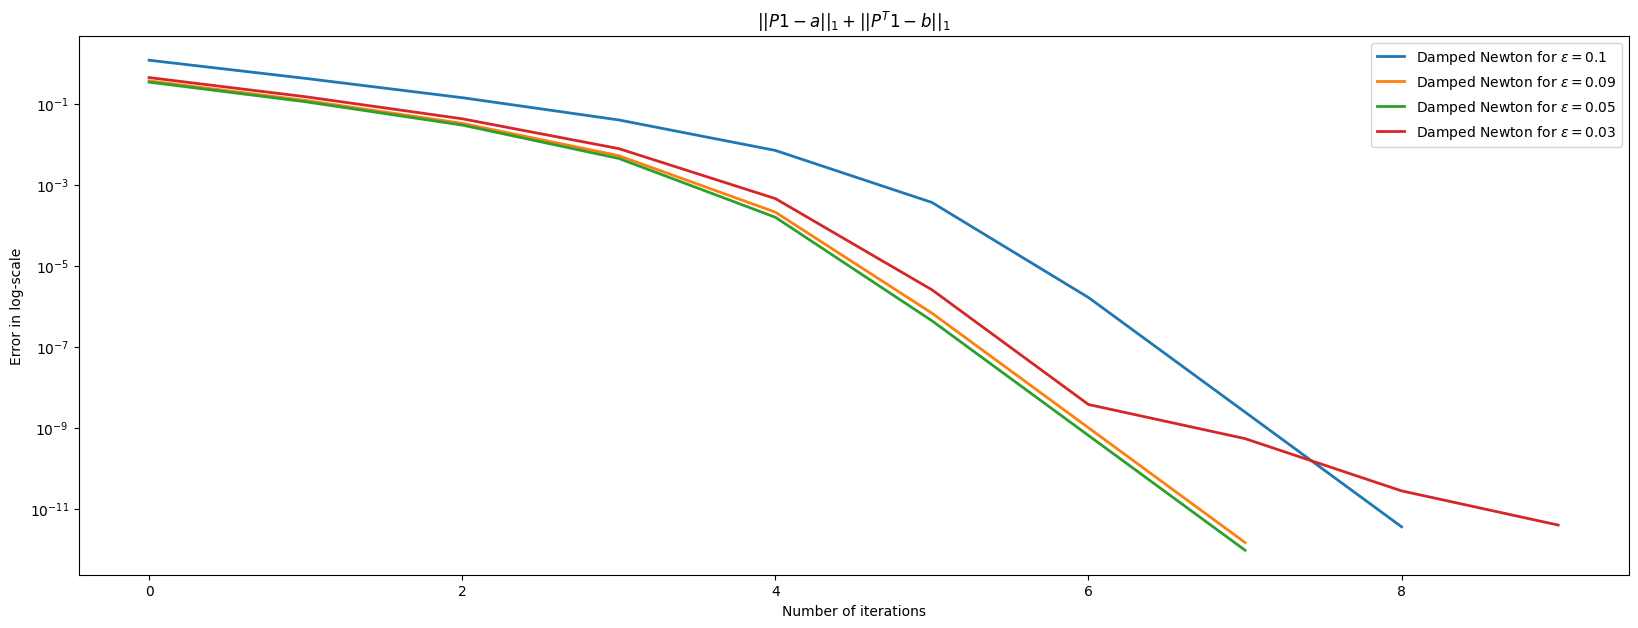


 Error plots can increase! The error is not the objective function!


In [49]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" )

for i in range( len(results_DampedNewton) ):
  error = np.asarray( results_DampedNewton[i]['error_a'] )+np.asarray( results_DampedNewton[i]['error_b'] )
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.savefig( "DampedNewtonVsSinkhorn_benchmark_annulusVSsquare_images/ErrorLinesearchNewton_final_cgL2.png" )
plt.show()
print( "\n Error plots can increase! The error is not the objective function!" )